In [8]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [57]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings

def load_thres_product(dir_path, time_range):
    #load time axis
    time_axis = load_time_label(dir_path, time_range = (-200,0), window = 25000, step = 10)
    
    #Load data
    product_data = np.load(dir_path+"cross-product.npy")
    
    #return the data in time_range
    selection_index = (time_axis > time_range[0]) & (time_axis < time_range[1]) 
    %reset -f in
    
    return product_data[selection_index][:, np.newaxis]

def plot_thres_prod(dir_path, time_range, power=1):
    #load time axis
    time_axis = load_time_label(dir_path, time_range = (-200,0), window = 25000, step = 10)
    
    #Load data
    product_data = np.load(dir_path+"cross-product.npy")
    
    #return the data in time_range
    selection_index = (time_axis > time_range[0]) & (time_axis < time_range[1]) 
    
    %reset -f in
    plt.figure(figsize = (20,2))
    plt.plot(time_axis[selection_index], np.log10(product_data[selection_index]**power))
    plt.title("Product of thresholded zero crossings for {}".format(dir_path[7:-1]))
    plt.xlabel("Time [s]")
    

---------

---------

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


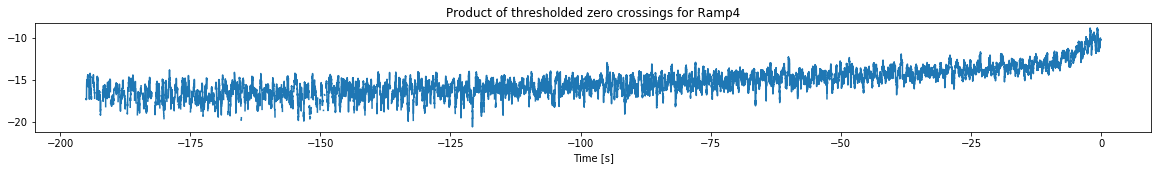

In [58]:
plot_thres_prod("./data/Ramp4/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


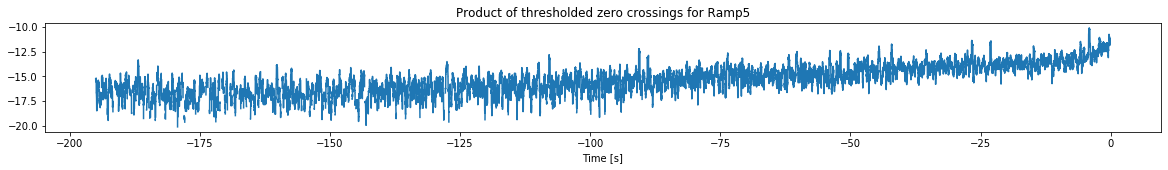

In [59]:
plot_thres_prod("./data/Ramp5/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


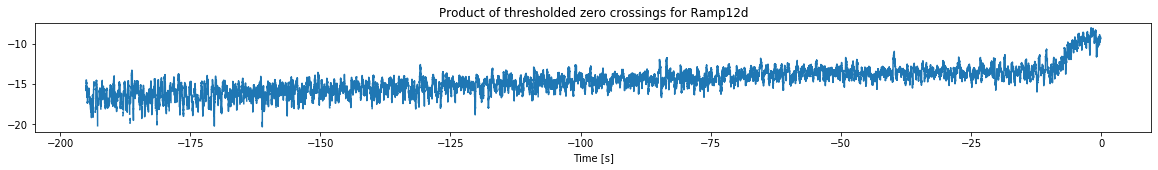

In [60]:
plot_thres_prod("./data/Ramp12d/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


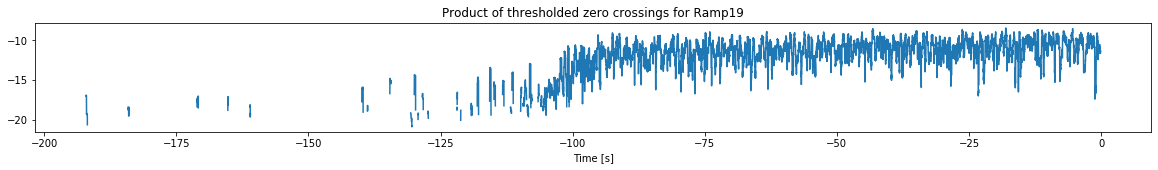

In [61]:
plot_thres_prod("./data/Ramp19/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


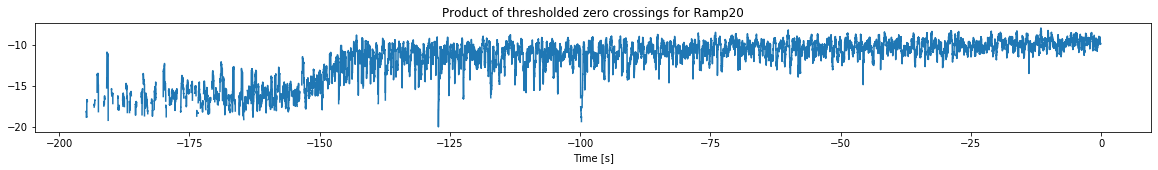

In [62]:
plot_thres_prod("./data/Ramp20/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


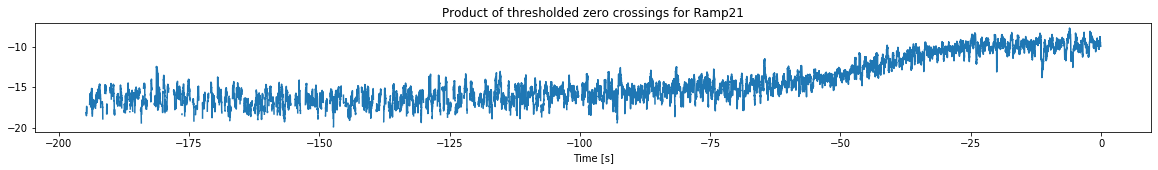

In [63]:
plot_thres_prod("./data/Ramp21/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


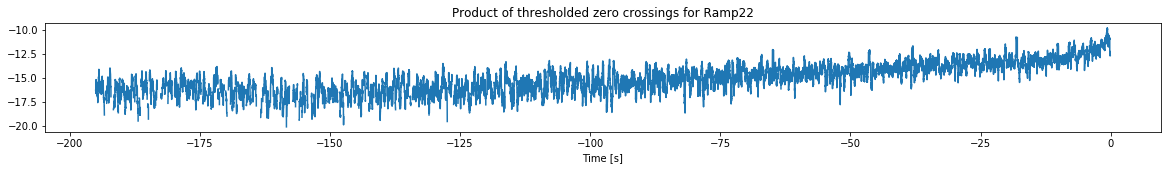

In [64]:
plot_thres_prod("./data/Ramp22/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


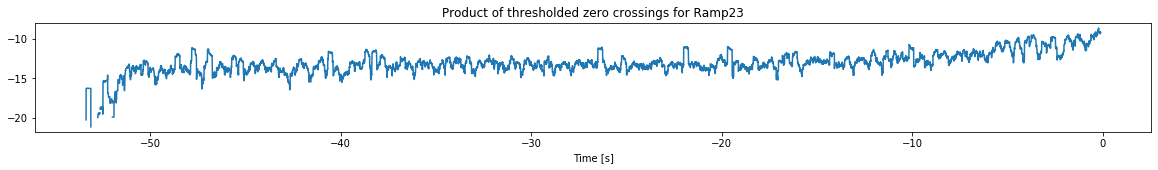

In [65]:
plot_thres_prod("./data/Ramp23/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


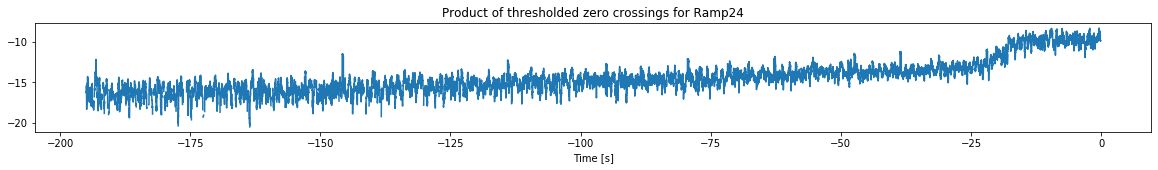

In [66]:
plot_thres_prod("./data/Ramp24/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


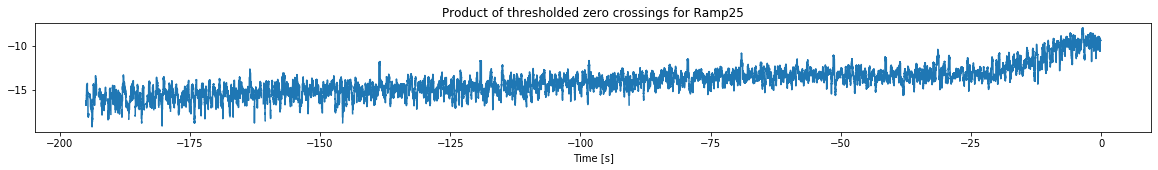

In [67]:
plot_thres_prod("./data/Ramp25/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


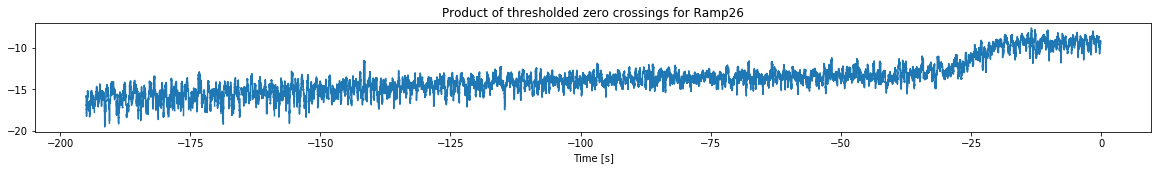

In [68]:
plot_thres_prod("./data/Ramp26/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


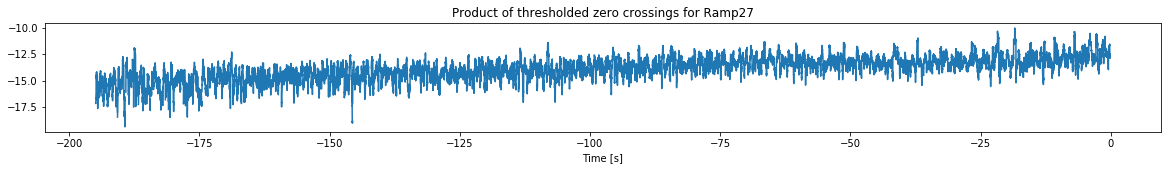

In [69]:
plot_thres_prod("./data/Ramp27/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


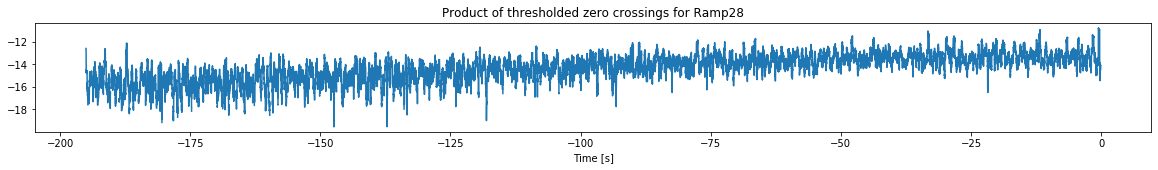

In [70]:
plot_thres_prod("./data/Ramp28/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


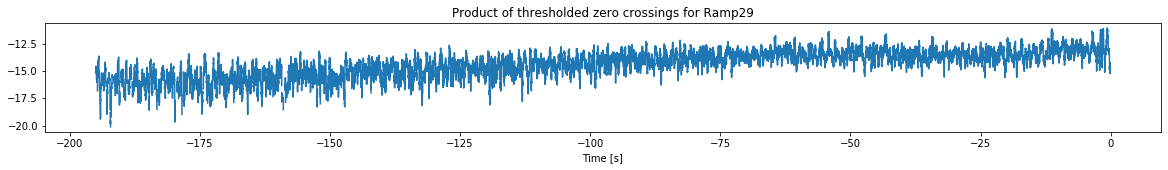

In [71]:
plot_thres_prod("./data/Ramp29/", time_range = (-195,-0.1), power = 1)

Flushing input history
Flushing input history


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log10


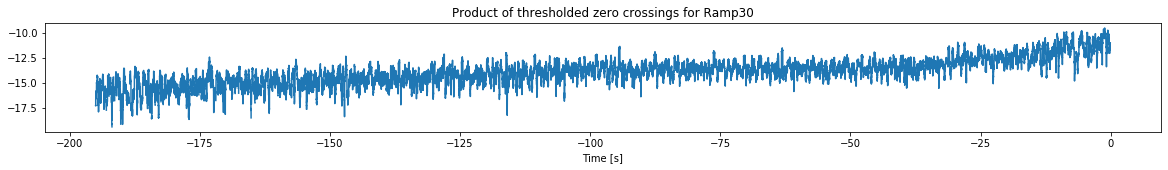

In [72]:
plot_thres_prod("./data/Ramp30/", time_range = (-195,-0.1), power = 1)

----------

Flushing input history
Flushing input history


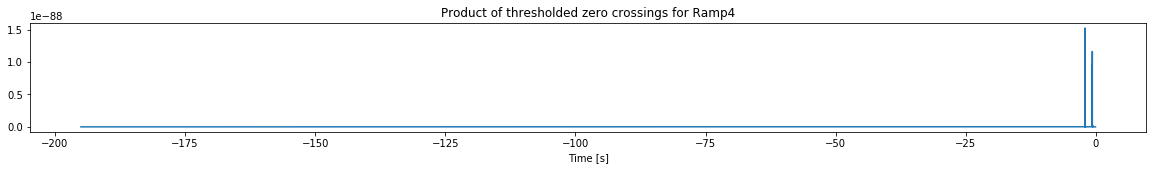

In [50]:
plot_thres_prod("./data/Ramp4/", time_range = (-195,-0.1), power = 10)

------------

In [90]:
def simulation(dir_path, time_range, power=1):
    
    #-----Load the data  
    time_axis = load_time_label(dir_path, time_range = (-200,0), window = 25000, step = 10)
    product_data = (np.load(dir_path+"cross-product.npy")[:, np.newaxis])**power
    
    #Calculate the training and the triggering time. 
    train_time = (time_range[0], time_range[0] + 10)
    test_time =  (time_range[0] + 10, time_range[1])
    
    #Return the data in time_range
    train_index = (time_axis > train_time[0]) & (time_axis < train_time[1])
    test_index = (time_axis > test_time[0]) & (time_axis < test_time[1]) 
    
    #Select the data
    train_product = product_data[train_index]
    test_product = product_data[test_index]
    test_time_axis = time_axis[test_index]
    
    #------Just fit the minmaxscaler & transform data
    scaler = MinMaxScaler()
    scaler.fit(train_product)
    test_product = scaler.transform(test_product)
    
    #------And then just plot the log
    plt.figure(figsize = (20,2))
    plt.plot(test_time_axis, test_product, color = "firebrick")
    plt.title("Tranformed data of {}".format(dir_path[7:-1]))
    plt.xlabel("Time [s]")

Flushing input history


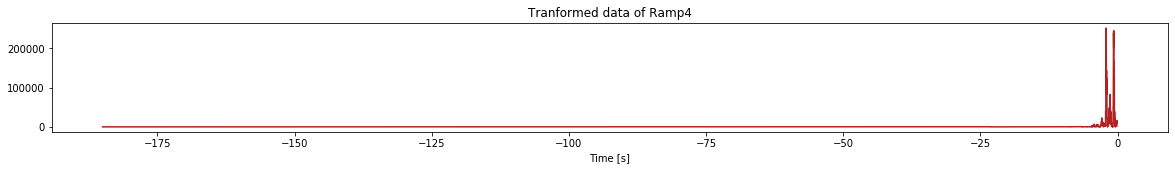

In [92]:
simulation("./data/Ramp4/", time_range = (-195,-0.1), power = 1)

Flushing input history


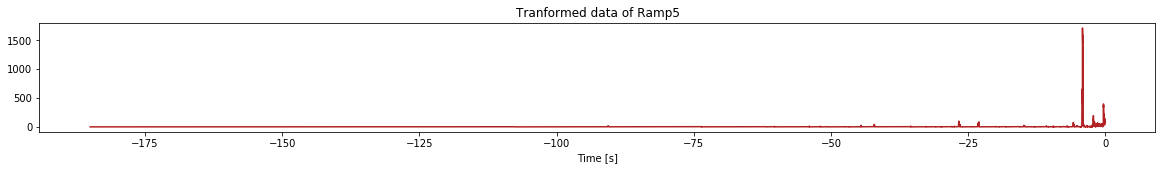

In [93]:
simulation("./data/Ramp5/", time_range = (-195,-0.1), power = 1)

Flushing input history


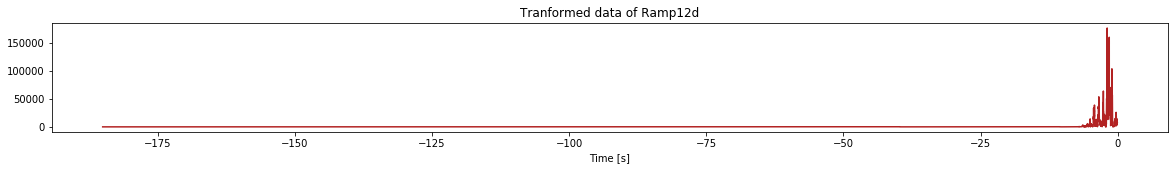

In [94]:
simulation("./data/Ramp12d/", time_range = (-195,-0.1), power = 1)

Flushing input history


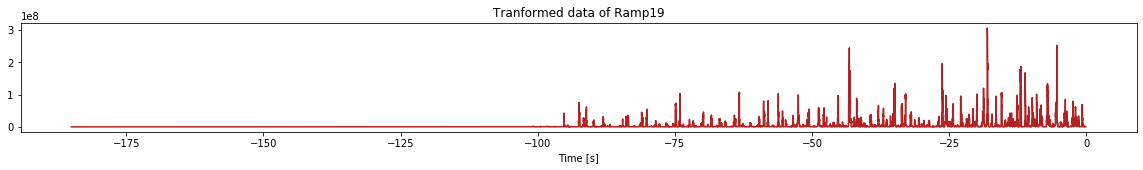

In [95]:
simulation("./data/Ramp19/", time_range = (-195,-0.1), power = 1)

Flushing input history


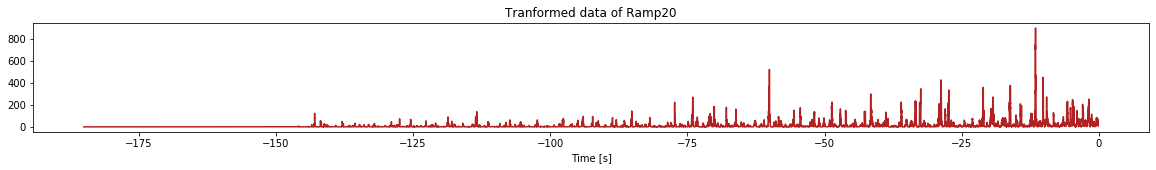

In [96]:
simulation("./data/Ramp20/", time_range = (-195,-0.1), power = 1)

Flushing input history


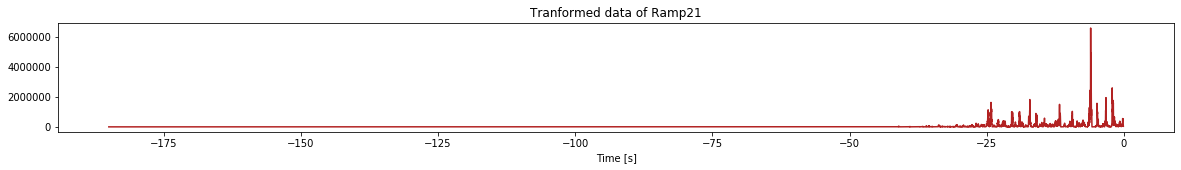

In [97]:
simulation("./data/Ramp21/", time_range = (-195,-0.1), power = 1)

Flushing input history


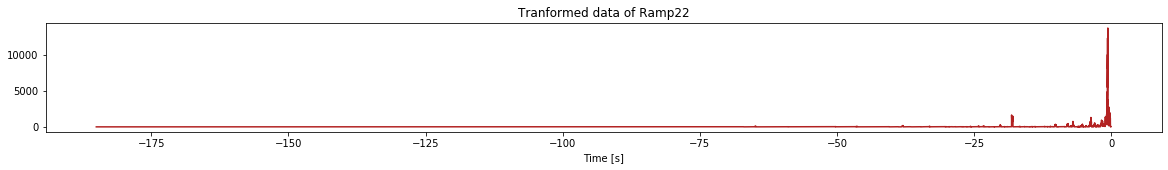

In [98]:
simulation("./data/Ramp22/", time_range = (-195,-0.1), power = 1)

Flushing input history


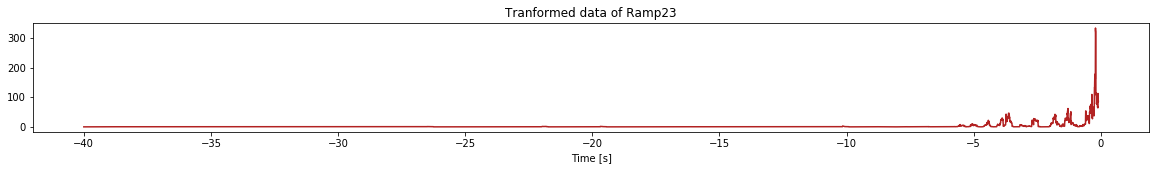

In [100]:
simulation("./data/Ramp23/", time_range = (-50,-0.1), power = 1)

Flushing input history


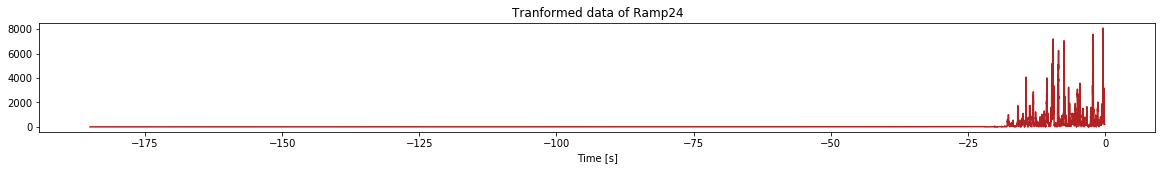

In [101]:
simulation("./data/Ramp24/", time_range = (-195,-0.1), power = 1)

Flushing input history


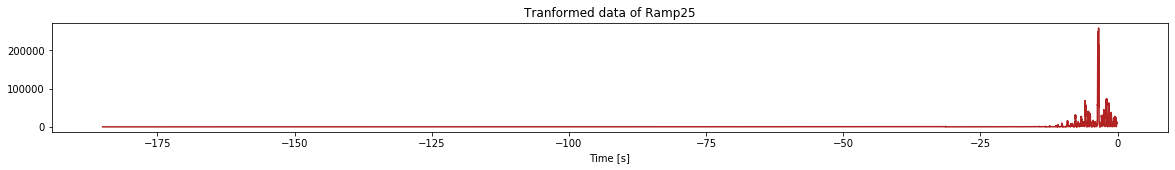

In [102]:
simulation("./data/Ramp25/", time_range = (-195,-0.1), power = 1)

Flushing input history


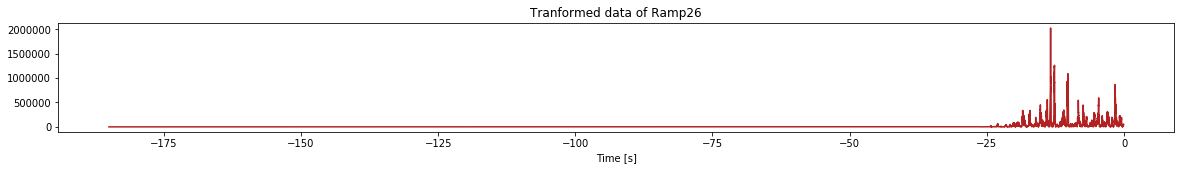

In [103]:
simulation("./data/Ramp26/", time_range = (-195,-0.1), power = 1)

Flushing input history


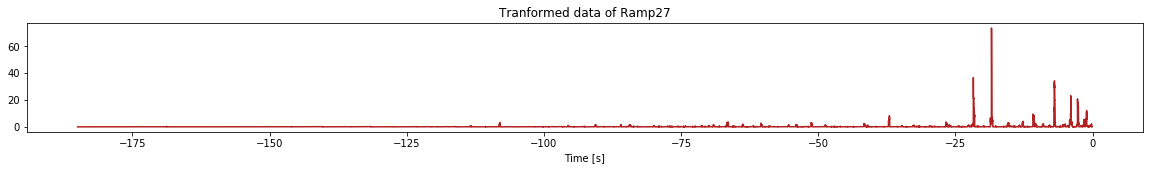

In [104]:
simulation("./data/Ramp27/", time_range = (-195,-0.1), power = 1)

Flushing input history


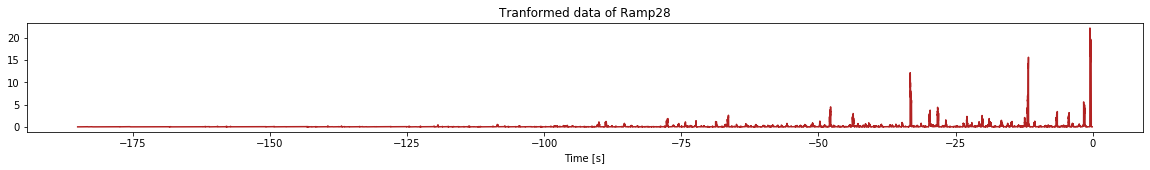

In [105]:
simulation("./data/Ramp28/", time_range = (-195,-0.1), power = 1)

Flushing input history


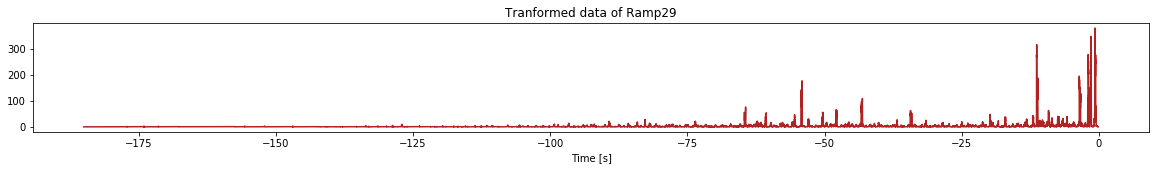

In [106]:
simulation("./data/Ramp29/", time_range = (-195,-0.1), power = 1)

Flushing input history


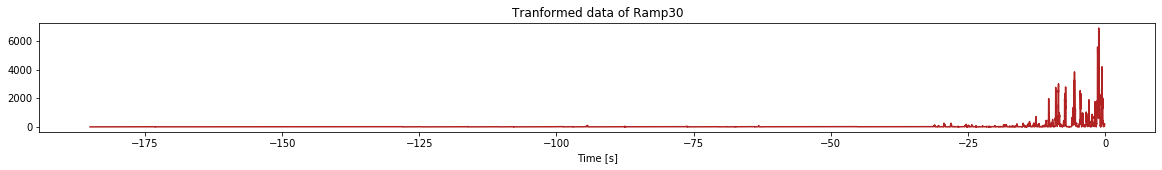

In [107]:
simulation("./data/Ramp30/", time_range = (-195,-0.1), power = 1)